# Algoritmus 2D Szenzor optim√°lis poz√≠ci√≥j√°ra

Vegy√ºnk egy 2D h≈ët√©rk√©pet kiindul√°sk√©ppen.

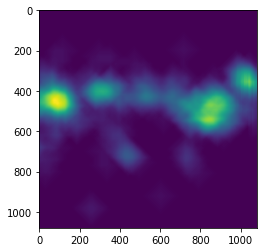

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from scipy import ndimage as ndi
from scipy.stats import mode
from skimage.feature import peak_local_max
from tqdm import tqdm
from place_me import optimize_v2, optimize_v3

data = np.loadtxt('data/heatmap2.txt')
data = 255 * data / data.max()
data = data[:, 2760:3840]
plt.imshow(data);

A h≈ët√©rk√©pen kiv√°lasztunk $n$ darab lok√°lis maximum helyet, amelyen elhelyez√ºnk $R$ sugar√∫ k√∂r√∂ket, ahol $n$ √©s $R$ az adott k√∂rnyezethez v√°lasztott. (P√©lda: $n$-t az alkalmaz√°st haszn√°l√≥ szem√©lyek sz√°m√°b√≥l kapjuk, $R$-t pedig √∫gy v√°lasztjuk, hogy a val√≥s√°gbeli m√©rete nagyj√°b√≥l az emberi k√©zzel azonos legyen). A h≈ët√©rk√©p nem determinisztikus, hanem val√≥sz√≠n≈±s√©gi jelleg≈±, vagyis a gener√°lt k√∂r√∂k pontos poz√≠ci√≥ja ingadozik: a h≈ët√©rk√©pen nagyobb √©rt√©ken nagyobb val√≥sz√≠n≈±s√©ggel tart√≥zkodik. A k√∂r√∂k nem fedhetnek egym√°sba. Az al√°bbi k√©p egy $n = 6$ √©s $R = 40\,pixel$ fel√°ll√°st mutat.

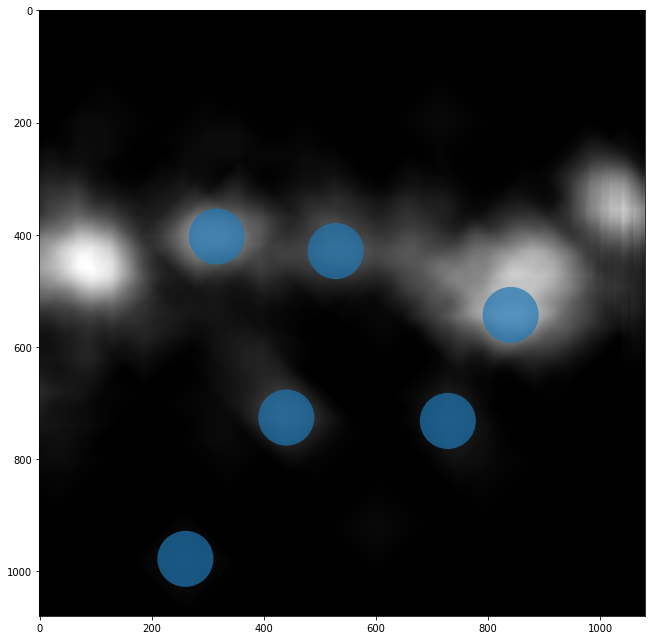

In [11]:
CIRCLE_RADIUS = 50

image_max = ndi.maximum_filter(data, size=20, mode='constant')

peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=6)

def plot_from_optimal_coords(data, peaks, arr=None):
    fig, ax = plt.subplots(figsize=(10, 9))
    ax.imshow(data, cmap=plt.cm.gray)
    ax.autoscale(False)
    if arr is not None:
        [x1, y1, x2, y2,  x3, y3] = arr
        ax.plot(x1, y1, 'yx', markersize=25, markeredgewidth=3)
        ax.plot(x2, y2, 'rx', markersize=25, markeredgewidth=3)
        if x3 is not None:
            ax.plot(x3, y3, 'bx', markersize=25, markeredgewidth=3)

    for y, x in peaks:
        circ = Circle((x, y), CIRCLE_RADIUS, alpha=0.7)
        ax.add_patch(circ)

    fig.tight_layout()

    plt.show()

plot_from_optimal_coords(data, peaks)

Minden szenzor a h≈ët√©rk√©p ker√ºlete ment√©n mozoghat. Egy szenzor eset√©n a lefedetts√©get √∫gy defini√°ljuk, hogy:
  - a lehet≈ë legt√∂bb k√∂rt l√°ssuk
  - a k√∂r√∂kb≈ël l√°tott ker√ºlet szeletek √∂sszege a lehet≈ë legnagyobb


√öjabb szenzorok hozz√°ad√°s√°n√°l egy adott k√∂rn√©l a m√°r kor√°bban lefedett ter√ºleteket nem vessz√ºk figyelembe - mivel ez nem hordoz √∫j inform√°ci√≥t. A folyamat az, hogy addig adunk hozz√° √∫j szenzorokat, am√≠g minden k√∂r l√°that√≥ legal√°bb egy szenzor sz√°m√°ra. A val√≥sz√≠n≈±s√©gi jelleg miatt ezt a szimul√°ci√≥t kell≈ëen sokszor futtatva megkapjuk, hogy mik lesznek az optim√°lis szenzor poz√≠ci√≥k.

Legyen $L(x) = 1$ ha $x > 0$, k√ºl√∂nben $0$, √∫n. egys√©gugr√°s f√ºggv√©ny, tov√°bb√° legyen egy adott $i$ objektum bel√°tott r√©sze $L_{i} = \frac{\sum l√°tott\,ker√ºlet}{2\pi R}$. Ekkor $n$ darab objektum eset√©n az $LF$ teljes lefedetts√©get a k√∂vetkez≈ëk√©ppen defini√°ljuk:
<center>
$LF = \sum_{i=1}^{n} (L(x_i) + L_i(x))$
</center>




A lentebbi √°br√°k ezzel a s√∫lyf√ºggv√©nnyel sz√°molt szimul√°ci√≥k eseteit mutatj√°k, ahol piros √©s s√°rga markerek mutatj√°k az optim√°lis szenzor poz√≠ci√≥kat. Az al√°bbi p√©ld√°ban 200-szor futtatjuk le a teljes szimul√°ci√≥t kiss√© k√ºl√∂nb√∂z≈ë poz√≠ci√≥j√∫ k√∂r√∂k√∂n, majd a KDE plotr√≥l a maximum √©rt√©ket v√°lasztjuk poz√≠ci√≥k√©nt, √©s azt √°br√°zoljuk. (**Note: Biztos, hogy ez helyes?**). 

In [3]:
%env RUST_LOG=0

NUM_OF_SIM = 50
r = np.array([])

for i in tqdm(range(NUM_OF_SIM)):
    peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=6)
    peaks = peaks + np.random.normal(0, CIRCLE_RADIUS / 4, size=peaks.shape)
    arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
    options = {
        'width': data.shape[1],
        'height': data.shape[0],
        'resolution': 500,
        'pixel_step': 20,
    }
    res = optimize_v2(*arr.T, **options)
    r = np.append(r, res)



env: RUST_LOG=0


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:14<00:00,  3.42it/s]


In [4]:
res = np.array(np.array_split(r, NUM_OF_SIM))

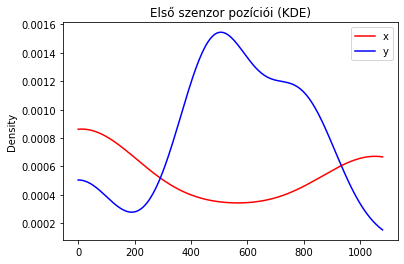

In [5]:
# First sensor
sns.kdeplot(res[:,0], color='red', cut=0, label="x")
sns.kdeplot(res[:,1], color='blue', cut=0, label="y")
plt.title("Els≈ë szenzor poz√≠ci√≥i (KDE)")
plt.legend();

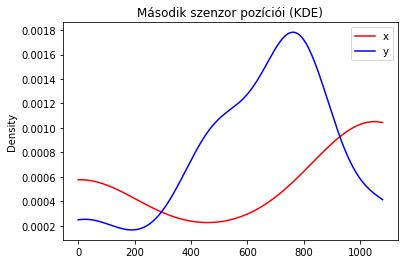

In [6]:
# Second sensor
sns.kdeplot(res[:,2], color='red', cut=0, label="x")
sns.kdeplot(res[:,3], color='blue', cut=0, label="y")
plt.title("M√°sodik szenzor poz√≠ci√≥i (KDE)")
plt.legend();

In [7]:
x1 = mode(res[:,0])
y1 = mode(res[:,1])
x2 = mode(res[:,2])
y2 = mode(res[:,3])

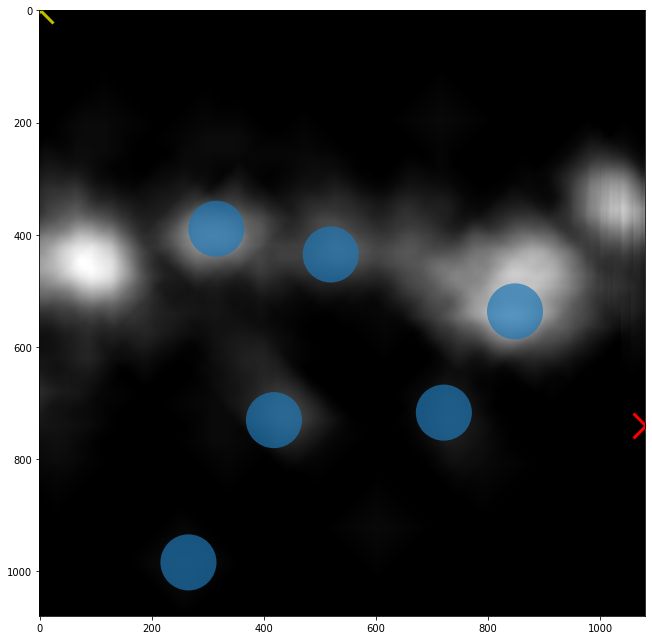

In [8]:
plot_from_optimal_coords(data, peaks, [x1.mode[0], y1.mode[0], x2.mode[0], y2.mode[0], None, None])

#### Szimul√°ci√≥ h√°rom szenzorral:

env: RUST_LOG=1

üéØ covered 97.35528036805711% (11.682633644166852/12)
optimal positions [
    Point {
        x: 0.0,
        y: 460.0,
    },
    Point {
        x: 960.0,
        y: 0.0,
    },
    Point {
        x: 880.0,
        y: 1080.0,
    },
]


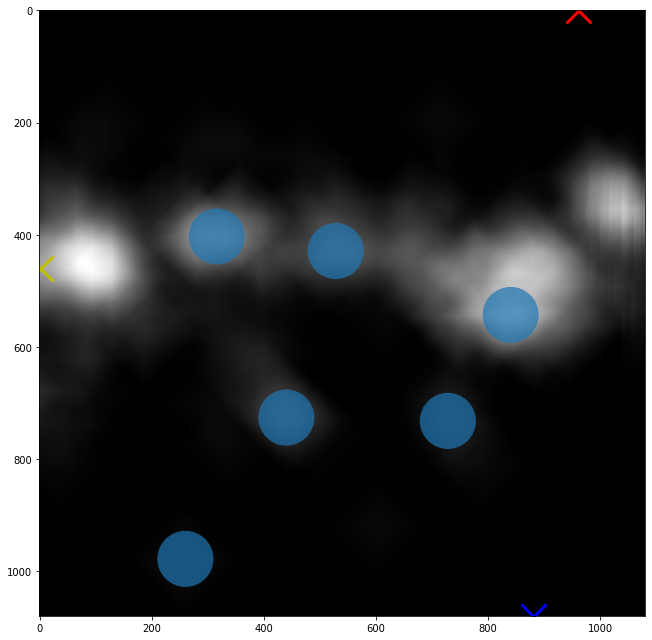

CPU times: user 36min 59s, sys: 9.45 s, total: 37min 8s
Wall time: 3min 20s


In [12]:
%%time
%env RUST_LOG=1

peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=6)
arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
options = {
    'width': data.shape[1],
    'height': data.shape[0],
    'resolution': 2280,
    'pixel_step': 20,
}
res = optimize_v3(*arr.T, **options)
plot_from_optimal_coords(data, peaks, res)

### Sz√°mol√°si r√©szletek

Legyen egy $r$ sugar√∫ k√∂r $O(O_x, O_y)$ k√∂z√©pponttal, tov√°bb√° tekints√ºnk k√©t $P(P_x, P_y)$ pontb√≥l kiindul√≥ sugarat, amelyek $P_1(P_{1x}, P_{1y})$ √©s $P_2(P_{2x}, P_{2y})$ pontokban metszik a k√∂rt (ha t√∂bb metsz√©spont is lehets√©ges, akkor a k√∂zelebbit v√°lasztjuk). Legyen a metsz√©spontokn√°l l√©v≈ë k√©t sz√∂g $\alpha_1$ √©s $\alpha_2$ standard x-y koordin√°tarendszerben, amelyek egyszer≈±en sz√°molhat√≥ak az $atan2(P_{iy} - O_y, P_{ix} - O_x)$ formul√°val. 

A szimul√°ci√≥ sor√°n minden k√∂rh√∂z hozz√° van rendelve egy √°llapot, amely t√°rolja, hogy mely sz√∂gtartom√°nyokban van lefedve. Ezek √∂sszefed≈ë r√©szei egy adott szenzor√°ll√°sn√°l egyes√≠t√©sre ker√ºlnek, azt√°n a fennmarad√≥ intervallumok hossz√°t kisz√°molva, majd $2\pi$-vel elosztva megkapjuk, hogy az adott k√∂r h√°nyad r√©sze lefedett, vagyis ez adja a fentebb eml√≠tett $L_i(x)$ f√ºggv√©nyt.